In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
from pprint import pprint

DATA_PATH = r"C:\Users\wilso\Desktop\Sleep-Stage-Classification\src\data_norm\collated.npz"

In [2]:
class Config():
    # Data
    sampling_rate = 100
    x_interval_mins = 30
    x_interval_seconds = x_interval_mins * sampling_rate
    
    # Matplotlib
    default_fig_size = (10,5)

    # Label values
    AWAKE = 0 # Awake
    N1 = 1 # N1
    N2 = 2 # N2
    N3 = 3 # N3
    REM = 4 # REM
    UNKNOWN = 5 # UNKNOWN
    
    label_dict = {
        AWAKE : "W",
        N1 : "A",
        N2 : "B",
        N3 : "C",
        REM : "R",
        UNKNOWN : "U",

        "W" : AWAKE,
        "A" : N1,
        "B" : N2,
        "C" : N3,
        "R" : REM,
        "U" : UNKNOWN,
    }

    stage_name = {
        AWAKE : "AWAKE",
        N1 : "N1",
        N2 : "N2",
        N3 : "N3",
        REM : "N4",
        UNKNOWN : "N5"
    }

    ann2label = {
        "Sleep stage W": 0,
        "Sleep stage 1": 1,
        "Sleep stage 2": 2,
        "Sleep stage 3": 3,
        "Sleep stage 4": 3,
        "Sleep stage R": 4,
        "Sleep stage ?": 5,
        "Movement time": 5
    }

class EEG_Fpz_Cz_Dataset():
    
    def __init__(self, collated_npz_pth, 
                 config=Config()):
        
        self.npz_pth = collated_npz_pth
        self.config = config
        
        data = np.load(self.npz_pth, allow_pickle=True)
        self.file_headers = data.files
        self.x = data["x"]
        self.y = data["y"]
        self.size_arr = list(data["size_arr"])
        
        self.xlen = len(self.x)
        self.ylen = len(self.y)
        self.num_blocks = self.xlen
    
        self.sampling_rate = config.sampling_rate
        self.x_interval_seconds = config.x_interval_seconds
        self.num_data_points = self.xlen * self.x_interval_seconds
        
        self.compressed_y_str = None
        self.compressed_y_ls = None
        self.awakeBlks = None
        self.classCount = None
        self.awakeBlksCount = None
        self.unawakeBlksCount = None
        del data
        
    def getX(self):
        return self.x
    
    def getY(self):
        return self.y
    
    def getCompressedYString(self):
        if self.compressed_y_str is not None: return self.compressed_y_str
        y = self.y
        prev = y[0]
        count = 1
        s = ""
        for i, curr in enumerate(y[1:]):
            if curr == prev:
                count += 1
                continue
            else:
                s += self.config.label_dict[prev] + str(count) + "|"
                count = 1
            prev = curr
        s += self.config.label_dict[prev] + str(count) + "|"
        self.compressed_y_str = s
        return s
    
    def getCompressedY(self):
        if self.compressed_y_ls is not None: return self.compressed_y_ls
        trimmed_y = self.y
        prev = trimmed_y[0]
        count = 1
#         start_idx = config.edge_mins * 2 
        start_idx = 0
        compressed_y_ls = []
        for idx, curr in enumerate(trimmed_y[1:]):
#             idx_w_offset = idx + config.edge_mins * 2 
            idx_w_offset  = idx
            if curr == prev:
                count += 1
                continue
            else:
                compressed_y_ls.append((self.config.label_dict[prev], count, start_idx, idx_w_offset))
                count = 1
                start_idx = idx_w_offset + 1
            prev = curr
        compressed_y_ls.append((self.config.label_dict[prev], count, start_idx, idx_w_offset + 1))
        self.compressed_y_ls = compressed_y_ls
        return compressed_y_ls
    
    def getAwakeBlocksCount(self):
        if self.awakeBlks is not None: return self.awakeBlks
        awakeBlks = []
        for idx, curr in enumerate(self.getCompressedY()):
            if curr[0] == self.config.label_dict[0]:
                awakeBlks.append(curr)
        self.awakeBlks = awakeBlks
        self.awakeBlksCount = len(awakeBlks)
        self.unawakeBlksCount = self.num_blocks - self.awakeBlksCount
        return awakeBlks
    
    def getClassCount(self):
        if self.classCount is not None: return self.classCount
        unique, counts = np.unique(self.y, return_counts=True)
        total = sum(counts)
        count_tuple = tuple(zip(counts, counts / total * 100))
        ret = dict(zip(unique, count_tuple))
        ret["total"] = total
        self.classCount = ret
        return self.classCount
    
    def getClassHist(self):
        h = {key:self.getClassCount()[key] for key in list(range(0,5))}
        counts, percentages = list(zip(*h.values()))
        plt.figure(figsize=self.config.default_fig_size)
        plt.bar([*h.keys()], counts)
        plt.title('Sleep Stage Count Histogram')
        plt.xlabel('Sleep Stage')
        plt.ylabel('Count')
        plt.show()
    
    def getSleepStagePlot(start_idx, end_idx):
        print("To-Do")
        
    def generateFullSleepStagePlot(self):
        print("Plot generation will take some time...")
        print("Please use getSleepStagePlot() to generate desired indexes.")
        fig, (ax1, ax2) = plt.subplots(2, figsize=(18,10))
        fig.suptitle("Sleep Stage Plots")

        plt.sca(ax1)
        plt.xticks(np.arange(0, len(self.y)+1, 20))
        plt.yticks(np.arange(0, 5))
        ax1.plot(range(len(self.y)), self.y)

        ax2.plot(range(self.xlen * self.x_interval_seconds), self.x.reshape(-1))
        plt.show()
        
    def getBlockPlot(self, blk_no):
        assert blk_no >= 0, "negative blk_no {blk_no} is invalid"
        assert blk_no < self.xlen, f"Invalid blk_no, max blk_no is {self.num_blocks-1}"
        fig = plt.figure(figsize=(18,5))
        plt.title(f"Block {blk_no} | Sleep Stage : {self.config.stage_name[self.y[blk_no]]}")
        plt.plot(range(self.x_interval_seconds), self.x[blk_no])

In [16]:
collated_data = EEG_Fpz_Cz_Dataset(DATA_PATH)
print(collated_data.x.shape) # x shape
print(collated_data.y.shape) # y shape
print(collated_data.size_arr) # Size of individual records making up the collated record.
collated_data.getAwakeBlocksCount()

(42308, 3000)
(42308,)
[841, 1127, 1103, 1186, 1025, 1009, 952, 911, 1235, 1200, 672, 1246, 843, 1016, 976, 1273, 1134, 1054, 1132, 1105, 1104, 1092, 928, 802, 1052, 977, 1028, 1004, 952, 952, 1762, 1144, 1003, 1002, 1773, 964, 920, 1535, 1274]


[('W', 60, 0, 59),
 ('W', 1, 99, 99),
 ('W', 1, 421, 421),
 ('W', 1, 556, 556),
 ('W', 16, 561, 576),
 ('W', 1, 580, 580),
 ('W', 2, 608, 609),
 ('W', 1, 712, 712),
 ('W', 17, 727, 743),
 ('W', 10, 747, 756),
 ('W', 18, 758, 775),
 ('W', 120, 781, 900),
 ('W', 1, 1147, 1147),
 ('W', 1, 1174, 1174),
 ('W', 1, 1177, 1177),
 ('W', 1, 1249, 1249),
 ('W', 9, 1252, 1260),
 ('W', 5, 1263, 1267),
 ('W', 1, 1365, 1365),
 ('W', 1, 1370, 1370),
 ('W', 2, 1395, 1396),
 ('W', 1, 1407, 1407),
 ('W', 20, 1410, 1429),
 ('W', 7, 1431, 1437),
 ('W', 2, 1544, 1545),
 ('W', 1, 1554, 1554),
 ('W', 1, 1592, 1592),
 ('W', 1, 1650, 1650),
 ('W', 2, 1747, 1748),
 ('W', 3, 1806, 1808),
 ('W', 1, 1815, 1815),
 ('W', 1, 1823, 1823),
 ('W', 1, 1886, 1886),
 ('W', 120, 1908, 2027),
 ('W', 1, 2067, 2067),
 ('W', 2, 2086, 2087),
 ('W', 9, 2170, 2178),
 ('W', 4, 2205, 2208),
 ('W', 1, 2223, 2223),
 ('W', 2, 2499, 2500),
 ('W', 4, 2504, 2507),
 ('W', 3, 2528, 2530),
 ('W', 3, 2533, 2535),
 ('W', 1, 2537, 2537),
 ('W', 

Plot generation will take some time...
Please use getSleepStagePlot() to generate desired indexes.


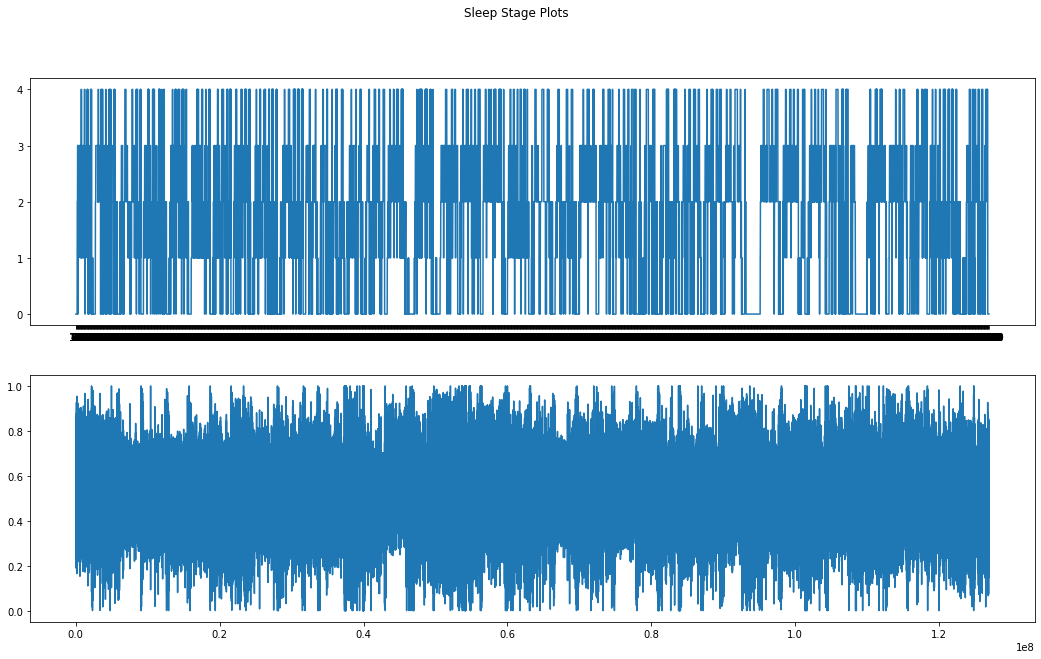

In [84]:
collated_data.generateFullSleepStagePlot()

In [20]:
# data_subset = EEG_Fpz_Cz_Dataset(DATA_PATH)
SUBSET_DATASIZE = 941
subX = collated_data.x[:SUBSET_DATASIZE]
subY = collated_data.y[:SUBSET_DATASIZE]
print(f"X shape: {subX.shape} | Y shape: {subY.shape}")

X shape: (941, 3000) | Y shape: (941,)


Value at index 0:	(4.690164566040039-0.8397011160850525j) 
Value at index 2999:	(4.690164566040039+0.8397011160850525j)
Value at index 1:	(3.371396541595459-0.6018497943878174j) 
Value at index 2998:	(3.371396541595459+0.6018497943878174j)


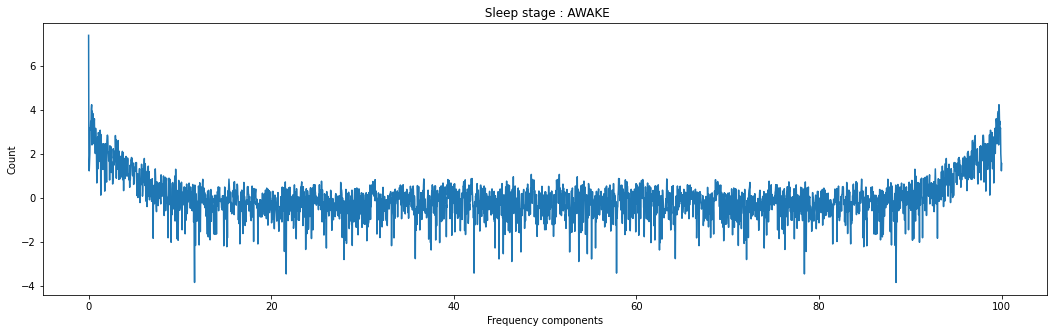

In [100]:
from scipy.fft import fft, ifft
config = Config()
freq = 100 # Sampling rate : 100 samples per s
N = 3000 # Number of points

TEST_IDX = 30

xf = fft(subX[TEST_IDX])
freq_rng = np.linspace(0, freq, N)

for i in range(2):
    print("Value at index {}:\t{}".format(i, xf[i + 1]), "\nValue at index {}:\t{}".format(xf.size -1 - i, xf[-1 - i]))
plt.figure(figsize=(18,5))
# plt.plot(np.log(xf))
plt.plot(freq_rng, np.abs(xf))
plt.title(f" Sleep stage : {config.stage_name[subY[TEST_IDX]]}")
plt.xlabel('Frequency components')
plt.ylabel('Count')

plt.plot(freq_rng, np.log(np.abs(xf)))


fig, (ax1, ax2) = plt.subplots(2, figsize=(18,10))
fig.suptitle("Sleep Stage Frequencies Plots")

plt.sca(ax1)
freq_rng = np.linspace(0, freq, N)
plt.xticks(freq_rng)
plt.yticks(np.arange(0, 5))
ax1.plot(range(len(self.y)), self.y)

ax2.plot(range(self.xlen * self.x_interval_seconds), self.x.reshape(-1))

plt.show()

In [68]:
subX[0].shape

(3000,)

C:\Users\wilso\Anaconda3\envs\ml-eq\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<BarContainer object of 3000 artists>

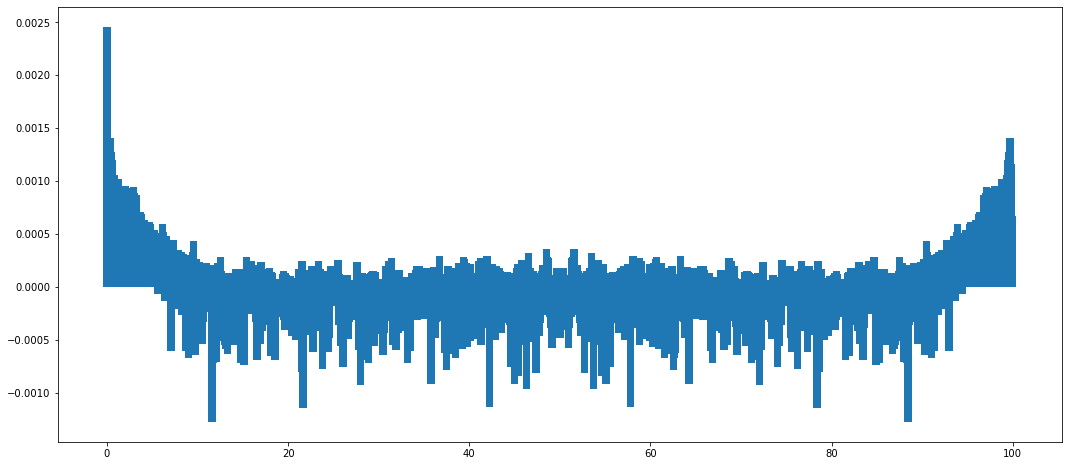

In [101]:
# frequency = 1 / T
plt.figure(figsize=(18,8))
f = np.linspace(0, 100, N)
plt.bar(f, np.log(xf) * 1 / N)  # 1 / N is a normalization factor

In [91]:
f = np.linspace(0, 100, N)

In [97]:
f[:5]

array([0.        , 0.03334445, 0.0666889 , 0.10003334, 0.13337779])